# Introduction: Lego datasets

<div style="background-color: #ebf4f7; color: #595959; text-align:left; vertical-align: middle; padding: 15px 25px 15px 25px; line-height: 1.6;">
    <div style="font-size:20px"><b>datasets/lego_sets.csv</b></div>
<ul>
    <li><b>set_num:</b> A code that is unique to each set in the dataset. <b><i>This column is critical, and a missing value indicates the set is a duplicate or invalid!</i></b></li>
    <li><b>set_name:</b> A name for every set in the dataset (note that this can be the same for different sets).</li>
    <li><b>year:</b> The date the set was released.</li>
    <li><b>num_parts:</b> The number of parts contained in the set.<b><i> 
        <li><b>theme_name:</b> The name of the sub-theme of the set.</li>
    <li><b>parent_theme:</b> The name of the parent theme the set belongs to. Matches the `name` column of the `parent_themes` csv file.</li>
</ul>

<div style="font-size:20px"><b>datasets/parent_themes.csv</b></div>
<ul>
    <li><b>id:</b> A code that is unique to every theme.</li>
    <li><b>name:</b> The name of the parent theme.</li>
    <li><b>is_licensed:</b> A Boolean column specifying whether the theme is a licensed theme.</li>
</ul>
    </div>

## Import libraries

In [355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autoviz.AutoViz_Class import AutoViz_Class

from sklearn.metrics import ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

In [356]:
%matplotlib inline

## Import data

In [357]:
df_original = pd.read_csv('https://raw.githubusercontent.com/KeithGalli/lego-analysis/master/datasets/lego_sets.csv')
df_parent_theme = pd.read_csv('https://raw.githubusercontent.com/KeithGalli/lego-analysis/master/datasets/parent_themes.csv')

## Data exploration and cleaning

In [358]:
df_merged = df_original.merge(df_parent_theme, right_on=['name'], left_on=['parent_theme']) # to join by the name 
# (df_parent_theme) and parent_theme (df_original) columns
df_merged.drop(columns='name_y', inplace=True)

In [359]:
def find_missing_themes():
    # This function is just to make the variables local instead of global 
    array1 = np.sort(np.unique(df_original['parent_theme']))
    array2 = np.sort(np.unique(df_parent_theme['name']))

    missing_themes = np.setdiff1d(array2, array1)
    
    return missing_themes

find_missing_themes()

array(['Primo', 'Quatro'], dtype=object)

When the files where merged, two themes, Primo and Quatro were dropped because they were not present in the parent_theme column of the Lego sets csv file.

In [360]:
df_merged.head()

,set_num,name_x,year,num_parts,theme_name,parent_theme,id,is_licensed
0,00-1,Weetabix Castle,1970,471.0,Castle,Legoland,411,False
1,00-2,Weetabix Promotional House 1,1976,NaN,Building,Legoland,411,False
2,00-3,Weetabix Promotional House 2,1976,NaN,Building,Legoland,411,False
3,00-4,Weetabix Promotional Windmill,1976,126.0,Building,Legoland,411,False
4,00-7,Weetabix Promotional Lego Village,1976,NaN,Building,Legoland,411,False


In [361]:
df_merged.tail()

,set_num,name_x,year,num_parts,theme_name,parent_theme,id,is_licensed
11981,8410-1,Swampfire,2010,22.0,Ben 10,Ben 10,270,True
11982,8411-1,ChromaStone,2010,21.0,Ben 10,Ben 10,270,True
11983,8517-1,Humungousaur,2010,14.0,Ben 10,Ben 10,270,True
11984,8518-1,Jet Ray,2010,NaN,Ben 10,Ben 10,270,True
11985,8519-1,Big Chill,2010,20.0,Ben 10,Ben 10,270,True


In [362]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11986 entries, 0 to 11985
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   set_num       11833 non-null  object 
 1   name_x        11833 non-null  object 
 2   year          11986 non-null  int64  
 3   num_parts     6926 non-null   float64
 4   theme_name    11833 non-null  object 
 5   parent_theme  11986 non-null  object 
 6   id            11986 non-null  int64  
 7   is_licensed   11986 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(4)
memory usage: 760.8+ KB


**Only two non-categorical values**

In [363]:
df_merged.shape

(11986, 8)

In [364]:
df_merged.size

95888

In [365]:
df_merged.describe()

,year,num_parts,id
count,11986.000000,6926.000000,11986.000000
mean,2002.304772,163.782558,306.811447
std,13.471680,334.206873,182.091827
min,1950.000000,-1.000000,1.000000
25%,1997.000000,10.250000,158.000000
50%,2006.000000,46.000000,324.000000
75%,2013.000000,173.000000,475.000000
max,2017.000000,5922.000000,610.000000


In [366]:
df_merged[df_merged['num_parts']<=0].head()

,set_num,name_x,year,num_parts,theme_name,parent_theme,id,is_licensed
453,4499536-1,Offre Speciale 4 Boites (7236 7238 7235 7241),2007,0.0,City,Town,50,False
931,65743-1,City Construction Value Pack (7246 7242 7248),2005,0.0,Construction,Town,50,False
935,65777-1,City Fire Value Pack (7238 7239 7240 7241),2005,0.0,Fire,Town,50,False
938,65799-1,City Fire Station Value Pack,2005,0.0,Fire,Town,50,False
939,65800-1,City Construction Set Value Pack,2005,0.0,Construction,Town,50,False


I would assume this sets are invalid, given that they have 0 or less number of parts

In [367]:
df_merged.iloc[[np.where(df_merged["num_parts"]==np.max(df_merged["num_parts"]))[0][0]]] # get a particular row given a condition

,set_num,name_x,year,num_parts,theme_name,parent_theme,id,is_licensed
4540,10189-1,Taj Mahal,2008,5922.0,Sculptures,Sculptures,276,False


In [368]:
df_merged.isnull().sum()

set_num          153
name_x           153
year               0
num_parts       5060
theme_name       153
parent_theme       0
id                 0
is_licensed        0
dtype: int64

**153 rows should be discarded because they are invalid sets**

In [369]:
df_merged[df_merged.duplicated()]

,set_num,name_x,year,num_parts,theme_name,parent_theme,id,is_licensed
5834,NaN,NaN,2014,NaN,NaN,Super Heroes,482,True
5843,NaN,NaN,2014,NaN,NaN,Super Heroes,482,True
5845,NaN,NaN,2013,NaN,NaN,Super Heroes,482,True
5861,NaN,NaN,2016,NaN,NaN,Super Heroes,482,True
5865,NaN,NaN,2017,NaN,NaN,Super Heroes,482,True
5868,NaN,NaN,2016,NaN,NaN,Super Heroes,482,True
5870,NaN,NaN,2015,NaN,NaN,Super Heroes,482,True
5871,NaN,NaN,2017,NaN,NaN,Super Heroes,482,True
5874,NaN,NaN,2017,NaN,NaN,Super Heroes,482,True
5877,NaN,NaN,2012,4.0,NaN,Super Heroes,482,True


These duplicated instances are going to be removed when NaNs are removed. 

In [370]:
df_merged.skew(axis=0)

year          -1.307649
num_parts      5.877923
id            -0.175524
is_licensed    2.474885
dtype: float64

*Pandas dataframe.skew() function return unbiased skew over requested axis Normalized by N-1. Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. https://en.wikipedia.org/wiki/Skewness*

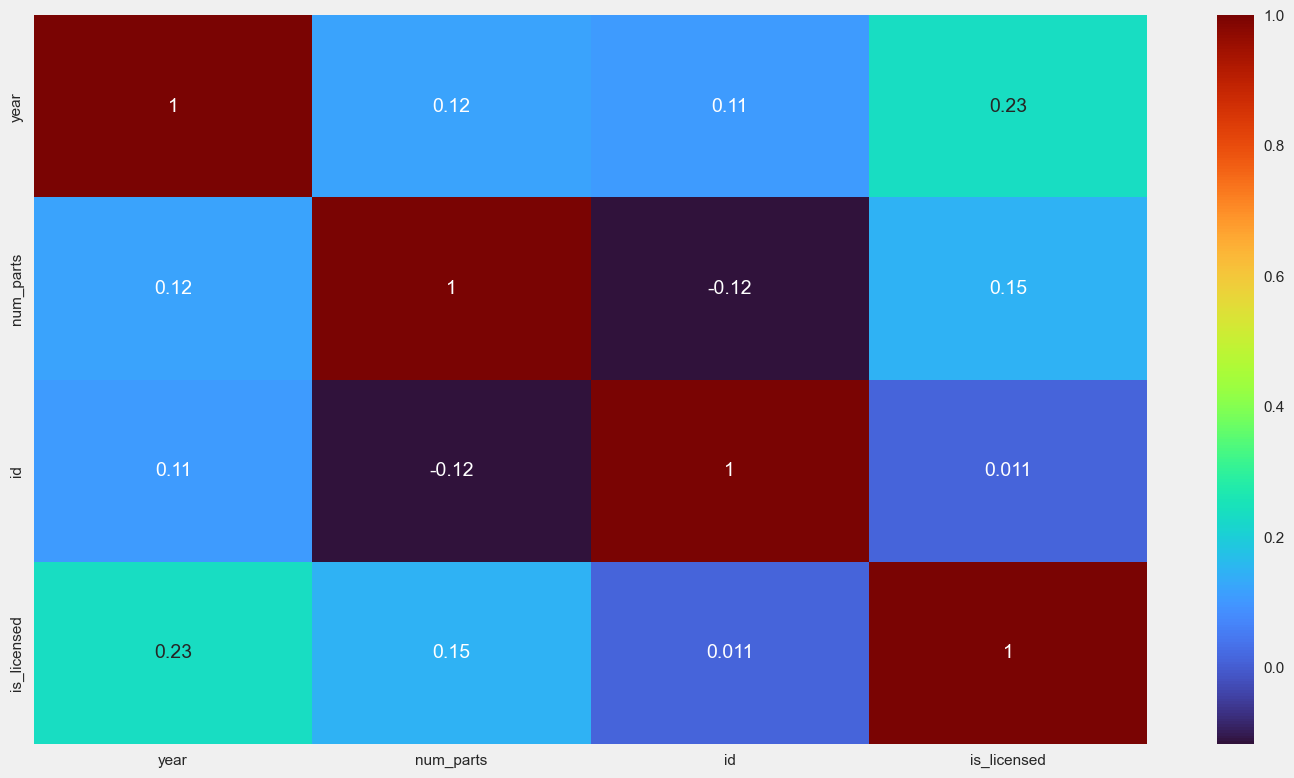

In [371]:
plt.figure(figsize=(16,9))
ax = sns.heatmap(df_merged.corr(),annot = True,cmap = 'turbo')
plt.show()

**No correlation between any numeric variabe; the license and year have the most correlation, but it is still low.**

### Remove NaNs

In [372]:
df_merged.dropna(subset=['set_num'], inplace=True)
df_merged.isnull().sum()

set_num            0
name_x             0
year               0
num_parts       4998
theme_name         0
parent_theme       0
id                 0
is_licensed        0
dtype: int64

Now our data is clean from missing values, the ones in num_parts are acceptable

## Visualization

Shape of your Data Set loaded: (11833, 8)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    8 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['set_num']
To fix data quality issues automatically, import FixDQ from autoviz...


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
set_num,object,0.000000,100,nan,nan,"Possible ID colum: drop before modeling process., 11833 rare categories: Too many to list. Group them into a single category or drop the categories., high cardinality with 11833 unique values: Use hash encoding or embedding to reduce dimension."
name_x,object,0.000000,88,nan,nan,"10512 rare categories: Too many to list. Group them into a single category or drop the categories., high cardinality with 10512 unique values: Use hash encoding or embedding to reduce dimension."
year,int64,0.000000,0,1950.000000,2017.000000,has 547 outliers greater than upper bound (2037.00) or lower than lower bound(1973.00). Cap them or remove them.
num_parts,float64,42.237810,NA,-1.000000,5922.000000,"4998 missing values. Impute them with mean, median, mode, or a constant value such as 123., has 767 outliers greater than upper bound (410.00) or lower than lower bound(-230.00). Cap them or remove them."
theme_name,object,0.000000,3,nan,nan,"371 rare categories: Too many to list. Group them into a single category or drop the categories., high cardinality with 390 unique values: Use hash encoding or embedding to reduce dimension."
parent_theme,object,0.000000,0,nan,nan,"84 rare categories: Too many to list. Group them into a single category or drop the categories., high cardinality with 109 unique values: Use hash encoding or embedding to reduce dimension."
id,int64,0.000000,0,1.000000,610.000000,No issue
is_licensed,bool,0.000000,0,0.000000,1.000000,No issue


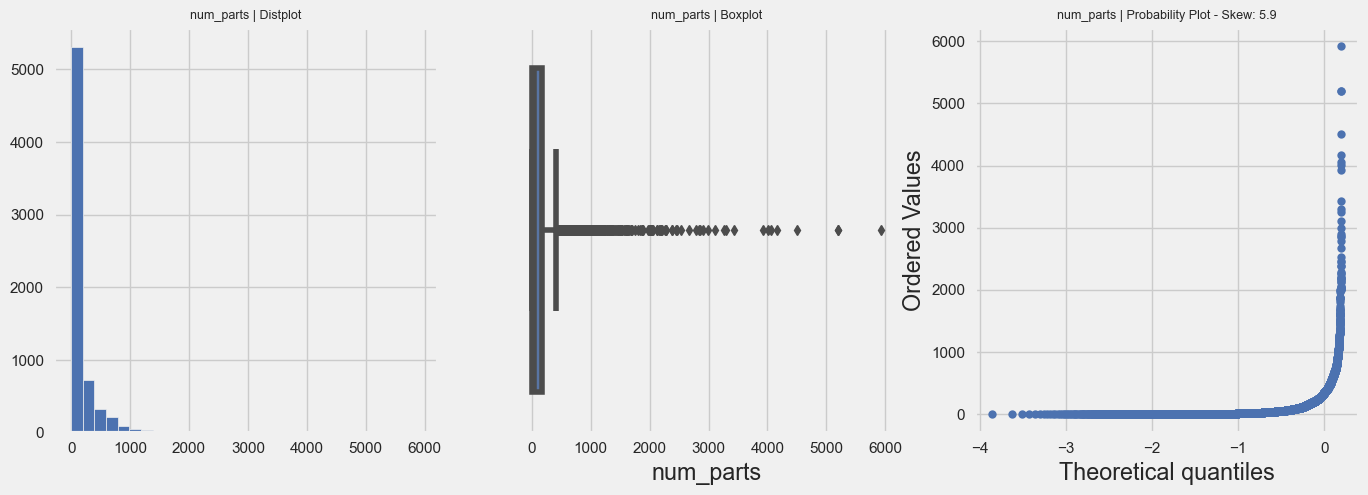

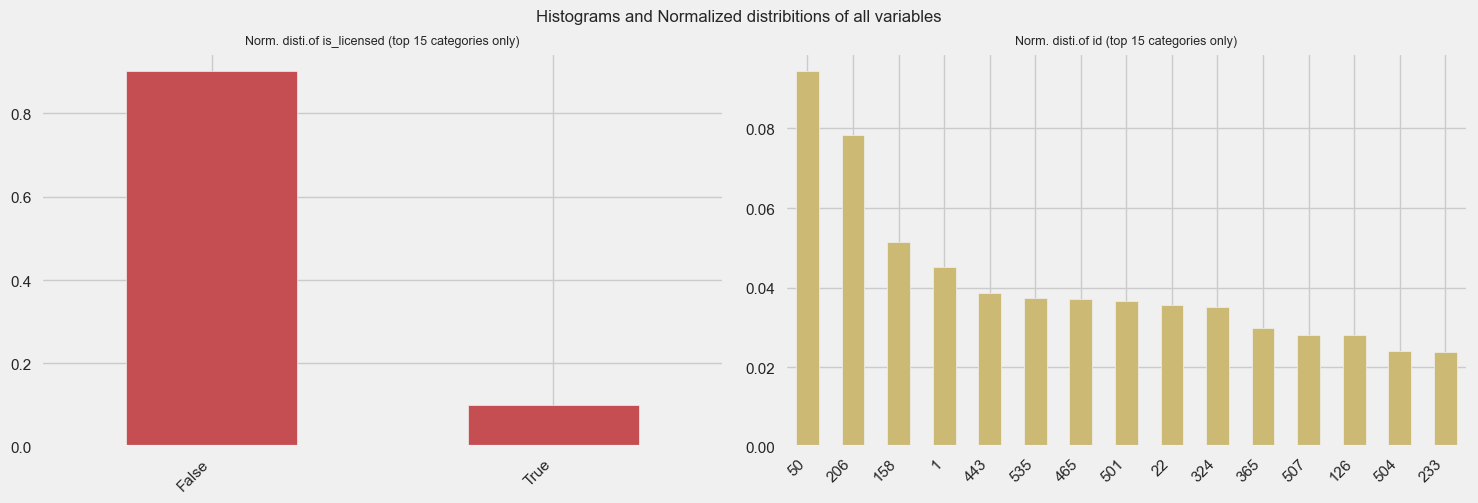

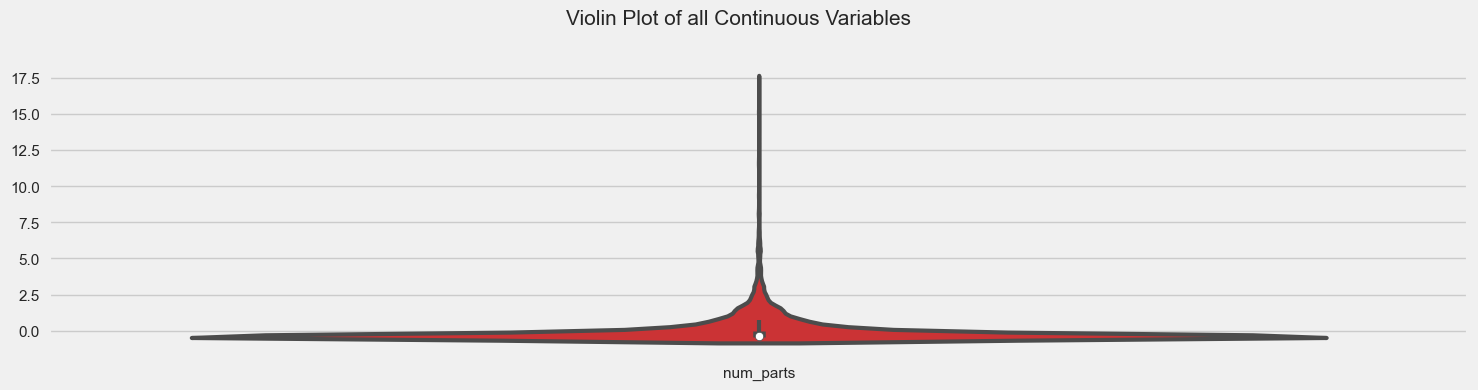

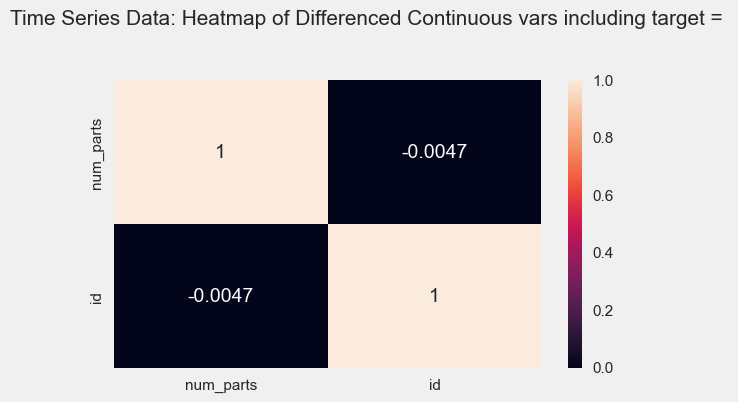

<Figure size 1500x0 with 0 Axes>

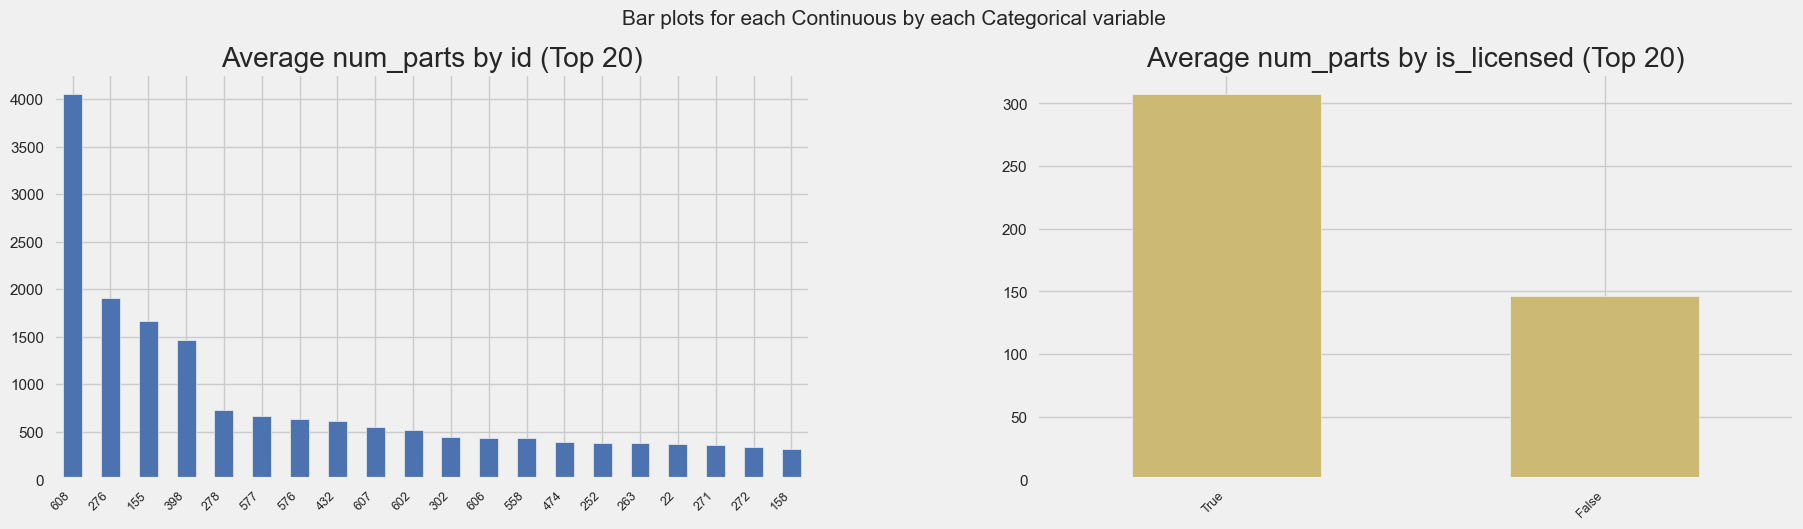

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Palillo\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Palillo\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Palillo\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Palillo\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\Palillo\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nlt

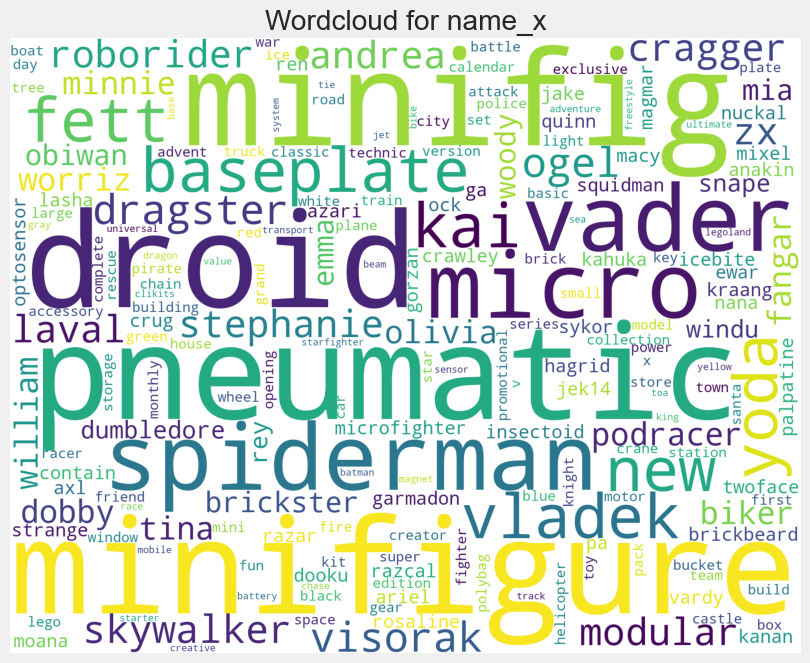

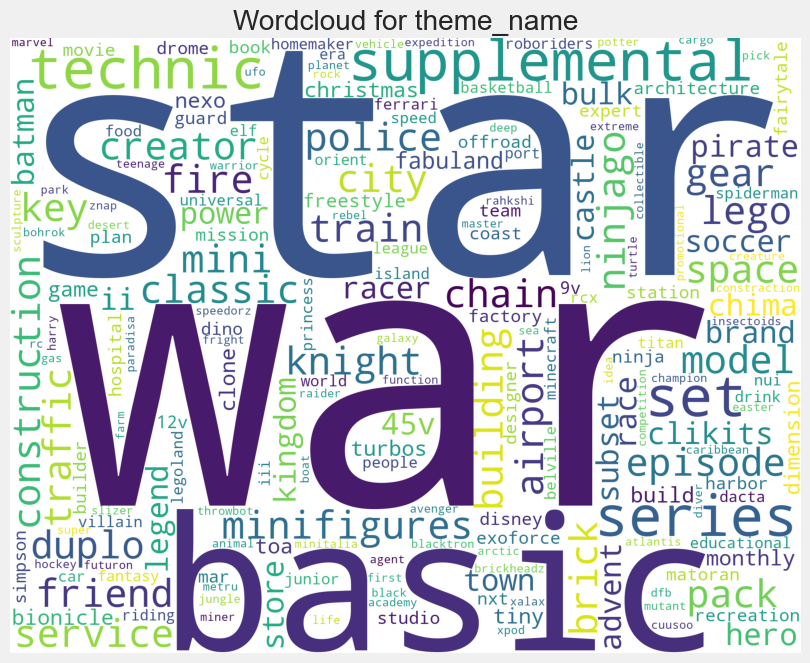

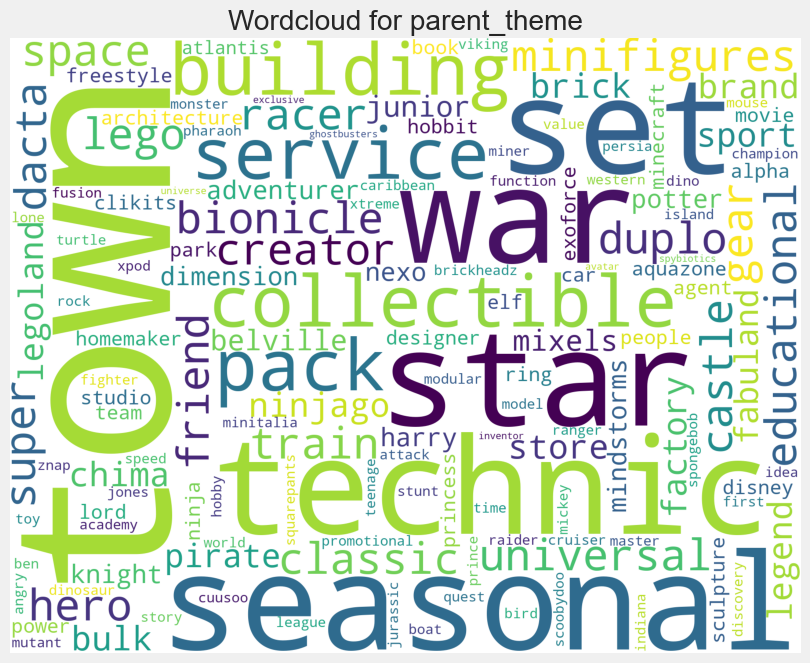

All Plots done
Time to run AutoViz = 17 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [373]:
AV = AutoViz_Class()
df_av = AV.AutoViz(filename="",dfte=df_merged)

**Autoviz reveals an intriguing trend: the average number of parts in licensed sets is twice that of non-licensed sets. This is noteworthy, as one might expect a proportional increase in price, considering that Lego set prices typically correlate with the number of pieces**

## What percentage of all licensed sets ever released were Star Wars themed?

In [374]:
df_licensed = df_merged[df_merged['is_licensed']].sort_values('year')
df_licensed

,set_num,name_x,year,num_parts,theme_name,parent_theme,id,is_licensed
3702,7161-1,Gungan Sub,1999,379.0,Star Wars Episode 1,Star Wars,158,True
3705,7171-1,Mos Espa Podrace,1999,NaN,Star Wars Episode 1,Star Wars,158,True
3690,7140-1,X-wing Fighter,1999,271.0,Star Wars Episode 4/5/6,Star Wars,158,True
3685,7130-1,Snowspeeder,1999,NaN,Star Wars Episode 4/5/6,Star Wars,158,True
3684,7128-1,Speeder Bikes,1999,93.0,Star Wars Episode 4/5/6,Star Wars,158,True
...,...,...,...,...,...,...,...,...
5692,71017-17,March Harriet™,2017,6.0,Batman,Super Heroes,482,True
5691,71017-16,Catman™,2017,NaN,Batman,Super Heroes,482,True
5690,71017-15,Zodiac Master™,2017,6.0,Batman,Super Heroes,482,True
5696,71017-20,The Mime™,2017,NaN,Batman,Super Heroes,482,True


In [375]:
licensed_themes_percentages = {}

for theme in np.unique(df_licensed['parent_theme']):
    length_licensed_theme = np.shape(df_licensed[df_licensed['parent_theme']==theme])[0]
    percentage = np.round((length_licensed_theme/len(df_licensed))*100, decimals=2)
    licensed_themes_percentages[theme] = percentage

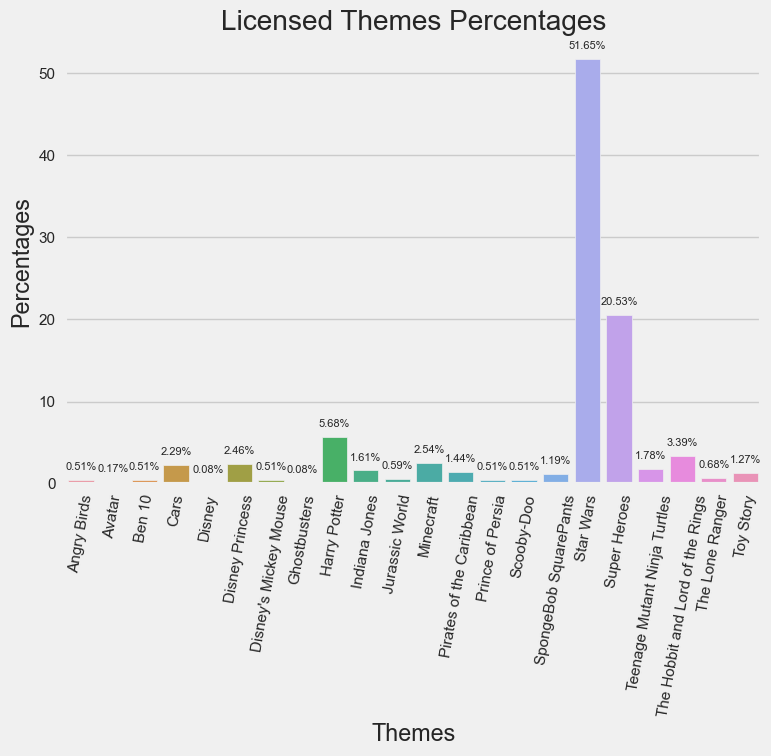

In [376]:
x_labels = list(licensed_themes_percentages.keys())
y_percentages = list(licensed_themes_percentages.values())

ax = sns.barplot(x=list(licensed_themes_percentages.keys()), y=y_percentages)
for i, value in enumerate(y_percentages):
    ax.text(i, value + 1, f'{value}%', ha='center', va='bottom', fontsize=8)
            
plt.xlabel('Themes')
plt.ylabel('Percentages')
plt.title('Licensed Themes Percentages')
plt.xticks(rotation=80)
plt.show()

**The percentage of licensed sets that were Star Wars themed is of 52%.**

## In which year was Star Wars not the most popular licensed theme (in terms of sets released that year)?

In [377]:
df_licensed_grouped = df_licensed.groupby(['year', 'parent_theme'])
df_licensed_grouped = df_licensed_grouped['is_licensed'].sum().reset_index()
df_licensed_grouped['count_by_year'] = df_licensed_grouped['is_licensed']
df_licensed_grouped.drop(columns='is_licensed', inplace=True)
df_licensed_grouped.head(10)

,year,parent_theme,count_by_year
0,1999,Star Wars,13
1,2000,Disney's Mickey Mouse,5
2,2000,Star Wars,26
3,2001,Harry Potter,11
4,2001,Star Wars,14
5,2002,Harry Potter,19
6,2002,Star Wars,28
7,2002,Super Heroes,3
8,2003,Harry Potter,3
9,2003,Star Wars,32


In [378]:
max_count_indices = df_licensed_grouped.groupby('year')['count_by_year'].idxmax()
rows_with_max_count = df_licensed_grouped.loc[max_count_indices]
rows_with_max_count

,year,parent_theme,count_by_year
0,1999,Star Wars,13
2,2000,Star Wars,26
4,2001,Star Wars,14
6,2002,Star Wars,28
9,2003,Star Wars,32
12,2004,Star Wars,20
16,2005,Star Wars,28
20,2006,Star Wars,11
24,2007,Star Wars,16
28,2008,Star Wars,23


In [379]:
rows_with_max_count[rows_with_max_count['parent_theme'] != 'Star Wars']

,year,parent_theme,count_by_year
82,2017,Super Heroes,72


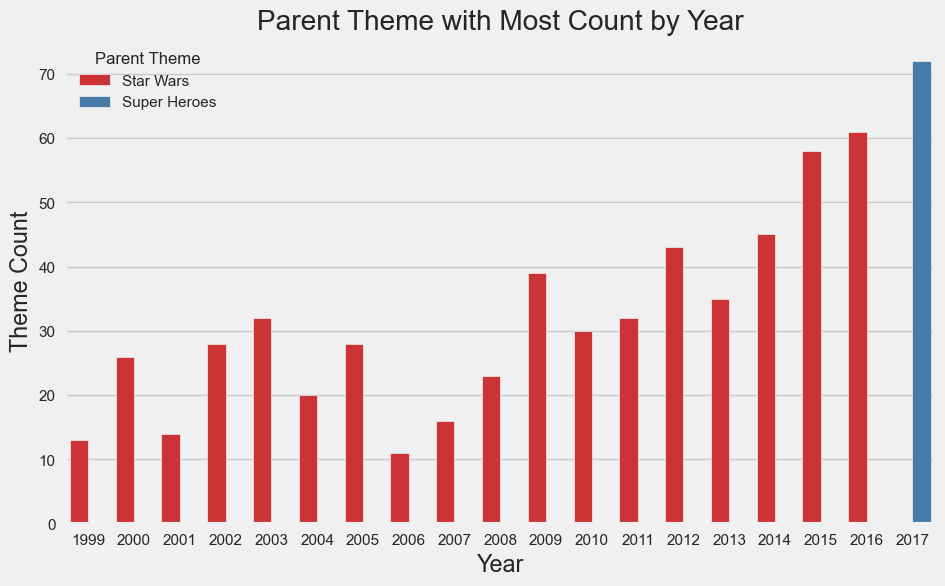

In [380]:
plt.figure(figsize=(10, 6))
sns.barplot(x='year', 
            y='count_by_year',
            hue='parent_theme',
            data=rows_with_max_count,
            )

plt.xlabel('Year')
plt.ylabel('Theme Count')
plt.title('Parent Theme with Most Count by Year')
plt.legend(title='Parent Theme')
plt.show()

**The year in which Star Wars was not the most popular licensed theme was 2017, where Super Heroes overcame it with 72 sets.**

## Which year had the most unique sets released?

In [381]:
df_merged['num_unique_sets'] = 1
df_sets_by_year = df_merged.groupby('year').sum().reset_index()[['year', 'num_unique_sets']]
df_sets_by_year.head()

,year,num_unique_sets
0,1950,7
1,1953,4
2,1954,14
3,1955,28
4,1956,12


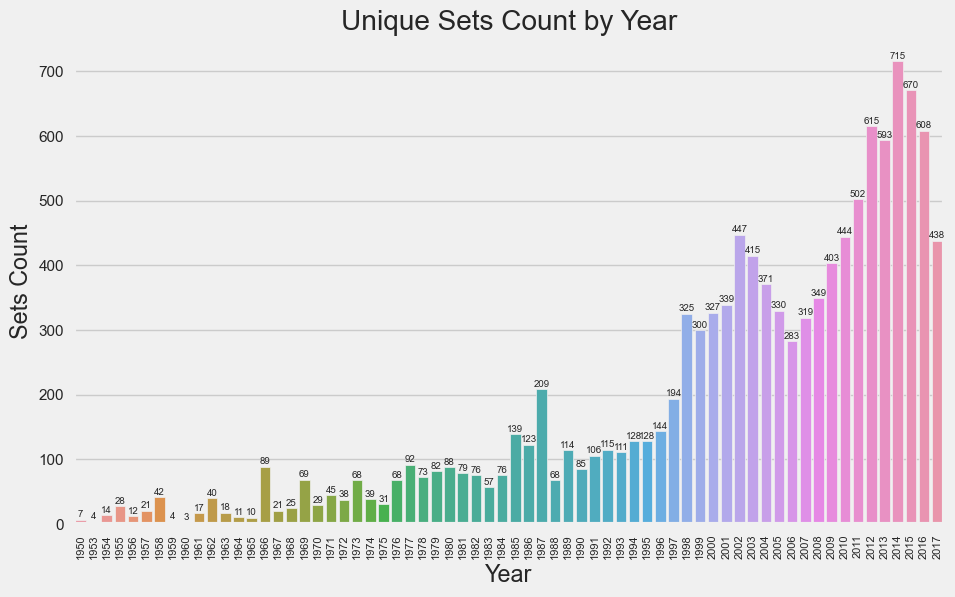

In [382]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='year', 
            y='num_unique_sets',
            data=df_sets_by_year,
            )
for i, value in enumerate(df_sets_by_year['num_unique_sets']):
    ax.text(i, value + 1, f'{value}', ha='center', va='bottom', fontsize=7)
            
plt.xlabel('Year')
plt.ylabel('Sets Count')
plt.title('Unique Sets Count by Year')
plt.xticks(rotation=90, size=8)
plt.show()

**The year 2014 had the most number of unique sets.**

## How many blocks per year were released in average?

In [383]:
df_average_blocks_by_year = np.round(df_merged.groupby('year')['num_parts'].mean(), decimals=2).reset_index()
df_average_blocks_by_year.head()

,year,num_parts
0,1950,8.67
1,1953,1.00
2,1954,17.43
3,1955,45.17
4,1956,11.89


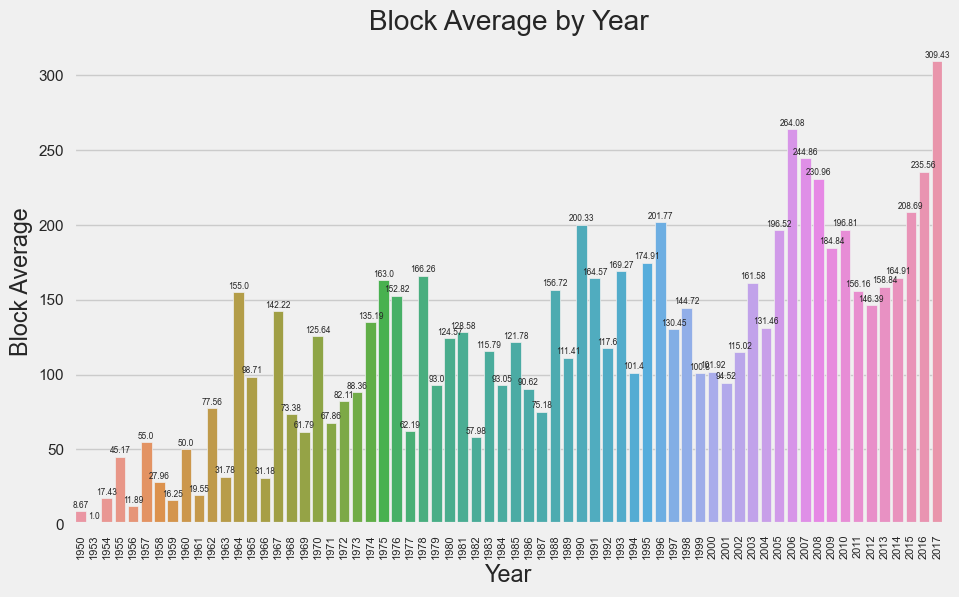

In [384]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='year', 
            y='num_parts',
            data=df_average_blocks_by_year,
            )
for i, value in enumerate(df_average_blocks_by_year['num_parts']):
    ax.text(i, value + 1, f'{value}', ha='center', va='bottom', fontsize=6)
            
plt.xlabel('Year')
plt.ylabel('Block Average')
plt.title('Block Average by Year')
plt.xticks(rotation=90, size=8)
plt.show()

**The year with the most blocks in average was 2017.**

## Prediction for the next 13 years of unique sets and average blocks released each year (2018-2030)

In [385]:
df_sets_by_year['avg_num_parts'] = df_average_blocks_by_year['num_parts']
df_sets_by_year.tail()

,year,num_unique_sets,avg_num_parts
61,2013,593,158.84
62,2014,715,164.91
63,2015,670,208.69
64,2016,608,235.56
65,2017,438,309.43


### Data splitting into training and testing data sets and model implementation

In [386]:
X = df_sets_by_year.copy()

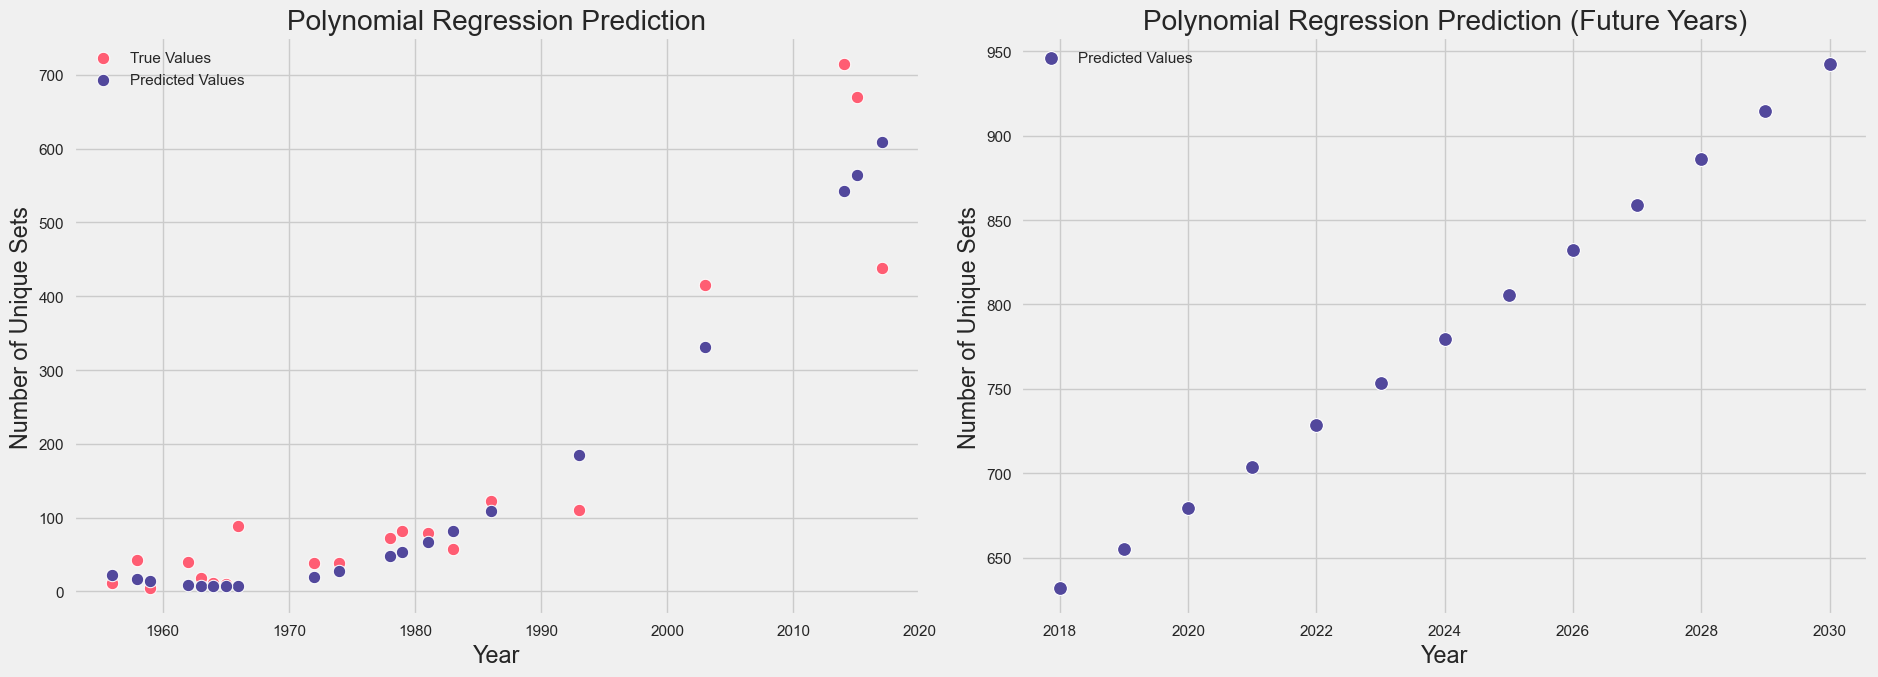

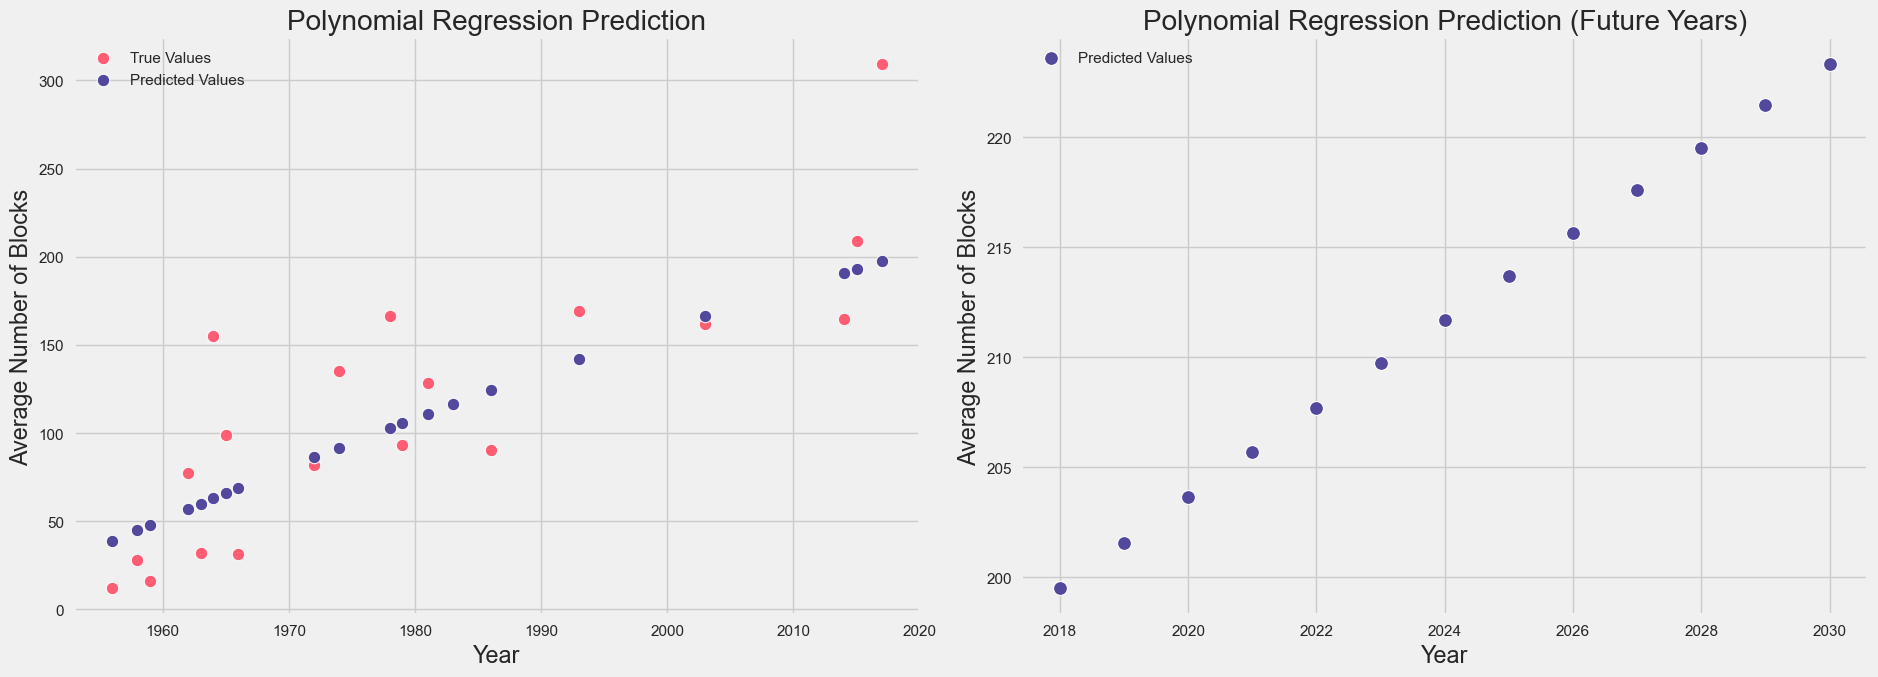

In [387]:
target_columns = ['num_unique_sets', 'avg_num_parts']
labels = ['Number of Unique Sets', 'Average Number of Blocks']

for i in range(len(target_columns)): # to predict both columns 
    target_column = int(np.where(df_sets_by_year.columns == target_columns[i])[0])

    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,:1],
                                                        X.iloc[:,target_column],
                                                        train_size=0.70,
                                                        random_state=4)
    
    poly = PolynomialFeatures(degree=2) # using a polynomial regression model of 2nd degree. 
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    linear_regression = LinearRegression() 
    linear_regression.fit(X_train_poly, y_train)
    
    y_predict = linear_regression.predict(X_test_poly)
    
    future_years = np.arange(2018, 2031).reshape(-1, 1)
    future_years_poly = poly.transform(future_years)
    
    if i == 0:
        df_future_predictions = pd.DataFrame(linear_regression.predict(future_years_poly), columns=[target_columns[i]])
        df_future_predictions.insert(loc=0, column='year', value=future_years)
    else:
        df_future_predictions[target_columns[i]] = linear_regression.predict(future_years_poly)
    
    # Plot
    plot_data = pd.DataFrame({'Year': X_test['year'], 'True Values': y_test, 'Predicted Values': y_predict})
    plot_future_data = pd.DataFrame({'Year': future_years.flatten(), 
                                     'Predicted Values': df_future_predictions[target_columns[i]]})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19, 7))

    # Plot 1: True and Predicted Values in the Testing Set
    sns.scatterplot(x='Year', y='True Values', 
                    data=plot_data, color='#FF5D73', label='True Values', s=80, ax=axes[0])
    sns.scatterplot(x='Year', y='Predicted Values', 
                    data=plot_data, color='#52489c', label='Predicted Values', s=80, ax=axes[0])
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel(labels[i])
    axes[0].set_title('Polynomial Regression Prediction')
    axes[0].legend()

    # Plot 2: Future Predictions
    sns.scatterplot(x='Year', y='Predicted Values', 
                    data=plot_future_data, color='#52489c', label='Predicted Values', s=100, ax=axes[1])
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel(labels[i])
    axes[1].set_title('Polynomial Regression Prediction (Future Years)')
    axes[1].legend()
    plt.tight_layout()
    plt.show()


In [388]:
df_sets_by_year_2030 = pd.concat([df_sets_by_year, df_future_predictions], ignore_index=True)
df_sets_by_year_2030.tail(30)

,year,num_unique_sets,avg_num_parts
49,2001,339.000000,94.520000
50,2002,447.000000,115.020000
51,2003,415.000000,161.580000
52,2004,371.000000,131.460000
53,2005,330.000000,196.520000
54,2006,283.000000,264.080000
55,2007,319.000000,244.860000
56,2008,349.000000,230.960000
57,2009,403.000000,184.840000
58,2010,444.000000,196.810000


**The predictions are not very accurate since the data is not really linear and it is a small dataset, despite the notorious augmentation of the number of sets and the number of parts in recent years.**